# Ant Farm Debugger

This notebook demonstrates how to utilze Peaknet API to train and test on PSANA data

Author: Po-Nan Li (Stanford EE and SLAC)

Last update: 2019/2/28


## Install

``` shell
conda create python=2.7 h5py jupyter -p ~/space/envs/peaknet
conda install psana-conda=1.4.2 -c lcls-rhel
conda install pytorch=0.1.12 torchvision cuda80 -c soumith
conda install tensorboardX
conda install pandas
```


## Import packages

In [1]:
#%reload_ext autoreload
%load_ext autoreload
%autoreload 2
import psana
import torch
# import torchvision
import numpy as np
import os
import time
from peaknet import Peaknet
from peaknet_utils import *

/reg/neh/home/liponan/space/envs/peaknet/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data

### Load data from psana

In [2]:
exp_name = "cxic0415"
# run = 90
# event_idx = 3963
run = 91
event_idx = 4633
# run = 95
# event_idx = 12159 # 12159, 13012

ds = psana.DataSource("exp=" + exp_name + ":run=" + str(run) + ":idx")
det = psana.Detector('DscCsPad')
this_run = ds.runs().next()
times = this_run.times()
num_events = len(times)
print("run", run, "number of events available", num_events)
env = ds.env()

evt = this_run.event(times[event_idx])
calib = det.calib(evt) * det.mask(evt, calib=True, status=True,
                          edges=True, central=True,
                          unbond=True, unbondnbrs=True)
print("calib", calib.shape)
print("max", calib.max())
print("min", calib.min())

('run', 91, 'number of events available', 5164)
('calib', (32, 185, 388))
('max', 14687.662)
('min', -1008.55444)


### Build labels (train)

In [3]:
# filename = "/reg/neh/home/liponan/data/cxic0415/r0090/cxic0415_0090.cxi" # 23817
# filename = "/reg/neh/home/liponan/data/cxic0415/r0095/cxic0415_0095.cxi" # 4239
filename = "/reg/neh/home/liponan/data/cxic0415/r0091/cxic0415_0091_streak.cxi" # 1635
t0 = time.time()
labels, eventIdxs = load_cxi_labels( filename, total_size=-1 )
t1 = time.time()
print("took " + str(t1-t0) + " s to build the training dataset")
print("labels", len(labels), len(labels[0]))

hits: 1365
took 18.944217205 s to build the training dataset
('labels', 1365, 6)


### Build labels (validate)

In [4]:
# filename = "/reg/neh/home/liponan/data/cxic0415/r0090/cxic0415_0090.cxi"
# filename = "/reg/neh/home/liponan/data/cxic0415/r0095/cxic0415_0095.cxi"
filename = "/reg/neh/home/liponan/data/cxic0415/r0091/cxic0415_0091_streak.cxi"
t0 = time.time()
val_labels, val_eventIdxs = load_cxi_labels( filename, total_size=10 )
t1 = time.time()
print("took " + str(t1-t0) + " s to build the val dataset")
print("val_labels", len(val_labels), len(val_labels[0]))

hits: 1365
took 0.00837087631226 s to build the val dataset
('val_labels', 10, 6)


### Test data loader

In [5]:
imgs = psana_img_loader(eventIdxs, 0, 5, det, this_run, times)
print("imgs shape", imgs.shape)

('imgs shape', (5, 32, 185, 388))


## Network

In [136]:
outdir = "/reg/d/psdm/cxi/cxic0415/res/liponan/antfarm_backup"
filename = os.path.join(outdir, "ant1_107328.pkl")
# filename = os.path.join(outdir, "5682.pkl")
model = torch.load(filename)
# print(model)


net = Peaknet()
net.model = model
net.model.cuda()

Darknet (
  (models): ModuleList (
    (0): Sequential (
      (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
      (leaky1): LeakyReLU (0.1, inplace)
    )
    (1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (2): Sequential (
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (leaky2): LeakyReLU (0.1, inplace)
    )
    (3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (4): Sequential (
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (leaky3): LeakyReLU (0.1, inplace)
    )
    (5): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (6): Sequential (
      (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(

## Predict

In [137]:
imgs = calib.reshape((1,32,185,388)) / calib.max()
predict_labels = []
print("imgs", imgs.shape)
# print("labels", len(labels), len(labels[0]))

('imgs', (1, 32, 185, 388))


In [138]:
results = net.predict( imgs, batch_size=32, conf_thresh=0.01, nms_thresh=0.5, use_cuda=True )


In [139]:
print(len(results[0]), "peaks found")
print((results[0]))

(32, 'peaks found')
[[0.020402165091767604, 0.041666666666666664, 4.189813900820039e-18, 2.1730531147660472e-12, 0.11866991221904755, 1.0, 0], [0.9999817828742825, 0.041666666666666664, 8.983814674277903e-17, 3.766599011856275e-12, 0.11810650676488876, 1.0, 0], [0.020408009996219556, 1.0, 3.259961392817951e-23, 3.1592609455702476e-15, 0.04728076234459877, 1.0, 0], [0.9999997664471062, 1.0, 2.5659768723837218e-23, 1.7769971257222957e-16, 0.04342089220881462, 1.0, 0], [0.9795916810327646, 0.041666666666666664, 6.287806620609521e-26, 9.210669217804328e-19, 0.024613836780190468, 1.0, 0], [0.9387755102040817, 0.041666666666666664, 1.878385730295623e-28, 7.99457945128997e-21, 0.017164718359708786, 1.0, 0], [0.9183673469387755, 0.041666666666666664, 1.4999865613234257e-28, 6.311893214023465e-21, 0.016890602186322212, 1.0, 0], [0.9591836734693877, 0.041666666666666664, 8.965991557165144e-29, 3.845437459756149e-21, 0.016311755403876305, 1.0, 0], [0.8979591836734694, 0.041666666666666664, 7.9592

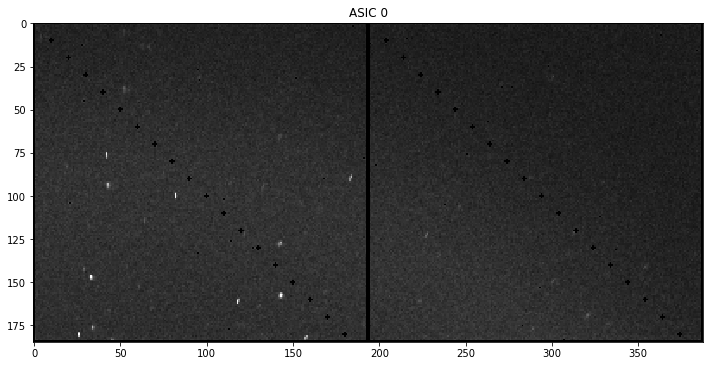

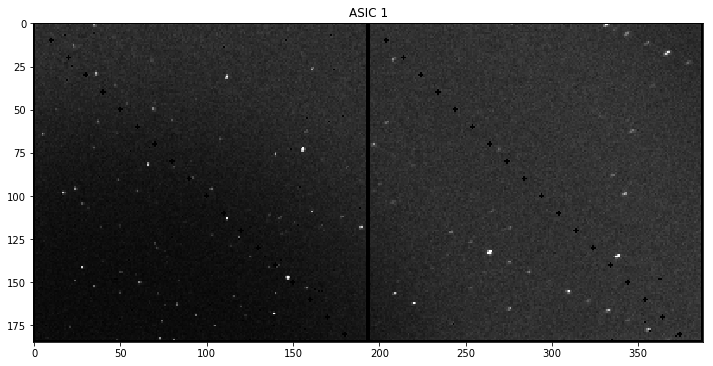

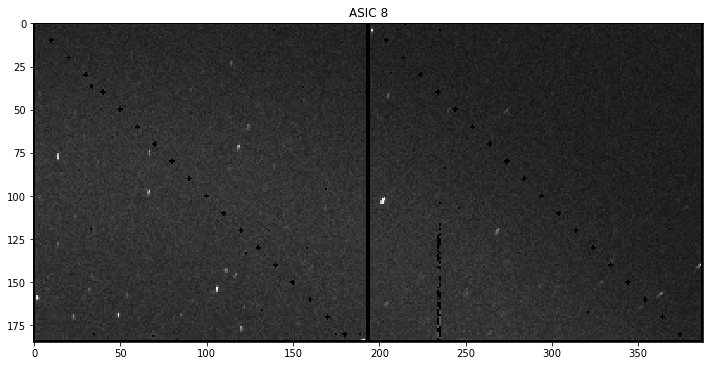

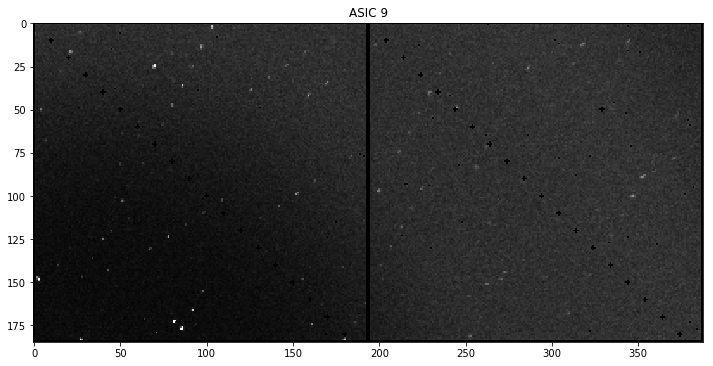

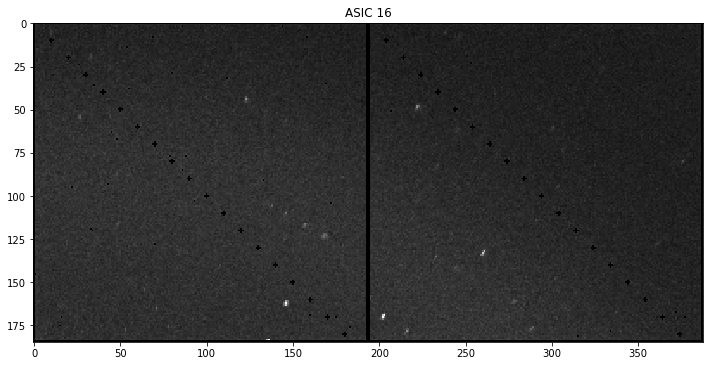

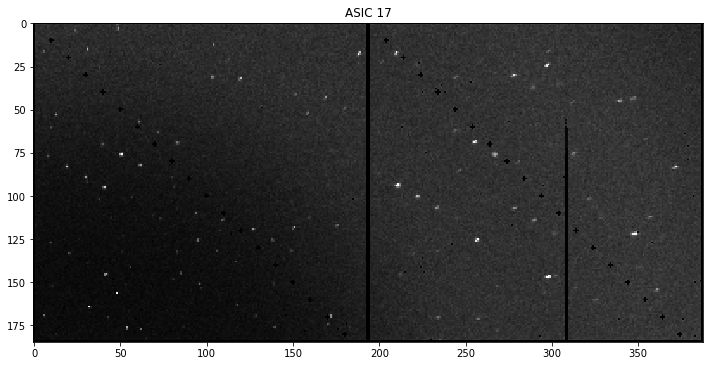

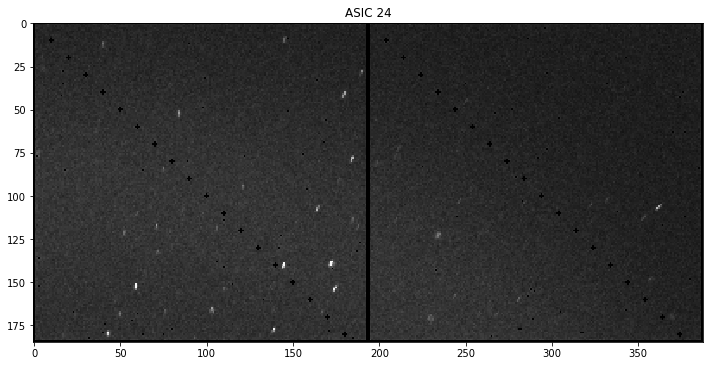

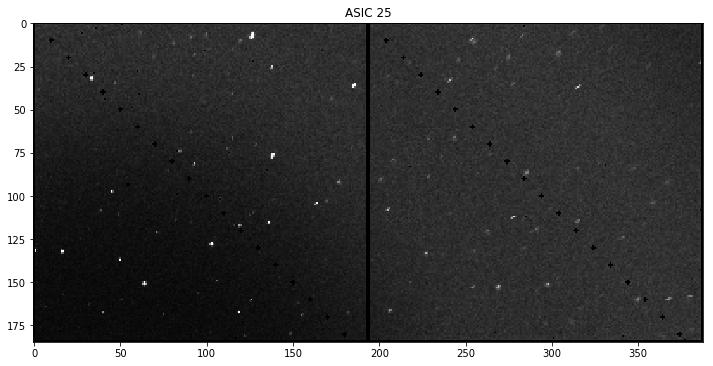

In [140]:
visualize(imgs, predict_labels, results, plot_label=False, plot_box=True, vmin=0, vmax=1.0,
          indexes=[0,1,8,9,16,17,24,25])

In [29]:
#a, b, c, d = build_dataset( filename, dev_size = 1, total_size=10 )